## Gradient descent in 1d: basic properties.

In [3]:
import numpy as np
import matplotlib.pylab as plt

A implementation of gradient descent for 2d functions.

In [104]:
class GradientDescent:
    def __init__(self, func, func_grad, theta0, alpha):
        """Basic implementation of 2d gradient descent.
        
        Args:
            func (function): 2d function we want to minimize.
            func_grad (function): gradient of func.
            theta0 (float): starting point.
            alpha (float): learning rate.
        """
        self.func = func
        self.func_grad = func_grad
        self.theta0 = theta0
        self.alpha = alpha
    
    def run(self, max_iter, plt_min, plt_save):
        """Runs gradient descent.
        
        Args:
            max_iter (int): max number of iterations.
            plt_save (str): path to save plot to.
        
        Returns:
            numpy.ndarray: array of all theta-values from start to end.
        """
        theta = self.theta0
        self.thetas = [self.theta0]

        iter_ = 0 # variable to keep track of number of iteration
        while iter_ <= max_iter:
            # Gradient descent update
            theta = theta - self.alpha * self.func_grad(theta)

            # Update number of iterations
            iter_ = iter_ + 1
            self.thetas.append(theta)

        self._plot(plt_min, plt_save)
    
    def _plot(self, min_theta, save_to):
        """Plots function and gradient descent steps as arrows.
        
        Args:
            save_to (str): path to save plot to.
        """
        plt.clf()
        
        # Plot contours
        min_x = -1
        max_x = 8
        domain = np.linspace(min_x, max_x, 100)
        theta1, theta2 = np.meshgrid(domain, domain)
        # Apply function to grid points
        func_grid = np.array(
            [self.func(np.array(c)) for c in zip(theta1.flat, theta2.flat)]
        ).reshape(theta1.shape)
        # Contour
        cs = plt.contour(theta1, theta2, func_grid, 10)
        
        # Plot starting point
        plt.plot(*self.thetas[0], color='r', marker='o', markersize=8)
        
        # Plot gradient descent steps as arrow
        for (start, end) in zip(self.thetas[:-1], self.thetas[1:]):
            arrow = np.concatenate([start, end - start])
            plt.quiver(*arrow, color='r', angles='xy', scale_units='xy', scale=1)
        
        # Plot minimum
        plt.plot(*min_theta, color='g', marker='o', markersize=8)

        # Save plot
        plt.clabel(cs, inline=1, fontsize=10)
        plt.hlines(0, min_x, max_x, color='k', linestyle='--')
        plt.vlines(0, min_x, max_x, color='k', linestyle='--')
        plt.legend()
        plt.savefig(save_to)

array([1.72645253, 1.65651393])

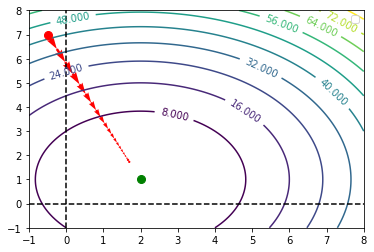

In [112]:
min_theta = np.array([2, 1])
f1 = lambda theta: np.dot(theta - min_theta, theta - min_theta)
f1_grad = lambda theta: 2 * (theta - min_theta)

gd1 = GradientDescent(f1, f1_grad, np.array([-0.5, 7.0]), 0.05)
gd1.run(20, min_theta, "sdfdf.pdf")
gd1.thetas[-1]

array([2.        , 1.65651393])

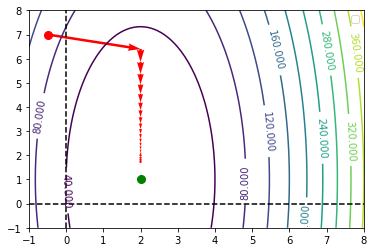

In [115]:
f2 = lambda theta: np.dot(np.array([10, 1]), (theta - min_theta)**2)
f2_grad = lambda theta: 2 * np.array([10, 1]) * (theta - min_theta)

gd2 = GradientDescent(f2, f2_grad, np.array([-0.5, 7.0]), 0.05)
gd2.run(20, min_theta, "sdfdf.pdf")
gd2.thetas[-1]

In [69]:
plt.clabel?